In [ ]:
#| hide
!pip install -Uqq nixtla
!pip install shap

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# SHAP Values for TimeGPT and TimeGEN

SHAP (SHapley Additive exPlanation) values use game theory to explain the output of any machine learning model. It allows us to explore in detail how exogenous features impact the final forecast, both at a single forecast step or over the entire horizon. 

When you forecast with exogenous features, you can access the SHAP values for all series at each prediction step, and use the popular [shap](https://shap.readthedocs.io/en/latest/) Python package to make different plots and explain the impact of the features.

This tutorial assumes knowledge on forecasting with exogenous features, so make sure to read our tutorial on [exogenous variables](https://docs.nixtla.io/docs/tutorials-exogenous_variables). Also, the `shap` package must be installed separately as it is not a dependency of `nixtla`.

`shap` can be installed from either [PyPI](https://pypi.org/project/shap/) or [conda-forge](https://anaconda.org/conda-forge/shap):
```
pip install shap

or

conda install -c conda-forge shap
```
For the official documentation of SHAP, visit: https://shap.readthedocs.io/en/latest/

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/21_shap_values')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/21_shap_values.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

In this example on SHAP values, we will use exogenous variables (also known as covariates) to improve the accuracy of electricity market forecasts. We'll work with a well-known dataset called `EPF`, which is publicly accessible [here](https://zenodo.org/records/4624805). 

This dataset includes data from five different electricity markets, each with unique price dynamics, such as varying frequencies and occurrences of negative prices, zeros, and price spikes. Since electricity prices are influenced by exogenous factors, each dataset also contains two additional time series: day-ahead forecasts of two significant exogenous factors specific to each market.

For simplicity, we will focus on the Belgian electricity market (BE). This dataset includes hourly prices (`y`), day-ahead forecasts of load (`Exogenous1`), and electricity generation (`Exogenous2`). It also includes one-hot encoding to indicate whether a specific date is a specific day of the week. Eg.: Monday (`day_0 = 1`), a Tuesday (`day_1 = 1`), and so on.

If your data depends on exogenous factors or covariates such as prices, discounts, special holidays, weather, etc., you can follow a similar structure.

In [ ]:
market = "BE"
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2011-01-09 00:00:00,32.54,63000.0,63065.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,BE,2011-01-09 01:00:00,21.55,58800.0,62715.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,BE,2011-01-09 02:00:00,15.71,58500.0,61952.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,BE,2011-01-09 03:00:00,10.58,54300.0,59262.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,BE,2011-01-09 04:00:00,10.32,51900.0,56883.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3. Forecasting electricity prices using exogenous variables

To produce forecasts we also have to add the future values of the exogenous variables. 

If your forecast depends on other variables, it is important to ensure that those variables are available at the time of forecasting. In this example, we know that the price of electricity depends on the demand (`Exogenous1`) and the quantity produced (`Exogenous2`). Thus, we need to have those future values available at the time of forecasting. If those values were not available, we can always [use TimeGPT to forecast them](https://docs.nixtla.io/docs/tutorials-exogenous_variables).

Here, we read a dataset that contains the future values of our features. In this case, we want to predict 24 steps ahead, therefore each `unique_id` will have 24 observations.

::: {.callout-important}
If you want to use exogenous variables when forecasting with TimeGPT, you need to have the future values of those exogenous variables too.
::: 

In [ ]:
future_ex_vars_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv')
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,70318.0,64108.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,67898.0,62492.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,68379.0,61571.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,64972.0,60381.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,62900.0,60298.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's call the `forecast` method, adding this information. To access the SHAP values, we also need to specify `feature_contributions=True` in the `forecast` method.

In [ ]:
timegpt_fcst_ex_vars_df = nixtla_client.forecast(df=df, 
                                                 X_df=future_ex_vars_df, 
                                                 h=24, 
                                                 level=[80, 90],
                                                 feature_contributions=True)
timegpt_fcst_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,46.036026,54.296190,57.903230,37.775864,34.168823
1,BE,2016-12-31 01:00:00,39.669830,47.451150,51.088530,31.888512,28.251130
2,BE,2016-12-31 02:00:00,42.782482,50.666080,53.985588,34.898884,31.579376
3,BE,2016-12-31 03:00:00,33.456486,41.924340,45.633470,24.988634,21.279505
4,BE,2016-12-31 04:00:00,33.013190,42.022102,45.891556,24.004282,20.134827


## 4. Extract SHAP values

Now that we have made predictions using exogenous features, we can then extract the SHAP values to understand their relevance using the `feature_contributions` attribute of the client. This returns a DataFrame containing the SHAP values and base values for each series, at each step in the horizon.

In [ ]:
shap_df = nixtla_client.feature_contributions
shap_df = shap_df.query("unique_id == @market")
shap_df.head()

,unique_id,ds,TimeGPT,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6,base_value
0,BE,2016-12-31 00:00:00,46.036026,27.686302,-10.114356,-0.110779,0.008743,0.010075,-0.083016,0.149803,-3.387345,0.633118,31.243480
1,BE,2016-12-31 01:00:00,39.669830,17.382830,-6.381124,-0.189463,-0.047664,-0.007513,-0.145481,0.176912,-4.135220,0.727788,32.288765
2,BE,2016-12-31 02:00:00,42.782482,20.109810,-5.255701,-0.117510,-0.038272,-0.000664,-0.142888,0.187600,-4.028637,0.684348,31.384396
3,BE,2016-12-31 03:00:00,33.456486,11.841421,-5.703259,-0.085908,-0.037913,-0.022507,-0.057077,0.047851,-3.946337,0.774264,30.645950
4,BE,2016-12-31 04:00:00,33.013190,9.895565,-6.216626,-0.041840,-0.039579,-0.022507,-0.040812,0.024252,-4.164020,0.755784,32.862972


In the Dataframe above, we can see that we have the SHAP values at every forecasting step, as well as the prediction from TimeGPT and the base value. Note that the base value is the prediction of the model if exogenous features were unknown. 

Therefore, the forecast from TimeGPT is equal to the sum of the base value and the SHAP values of each exogenous feature in a given row.

## 5. Make plots using `shap`

Now that we have access to SHAP values we can use the `shap` package to make any plots that we want.

### 5.1 Bar plot
Here, let's make bar plots for each series and their features, so we can see which features impacts the predictions the most.

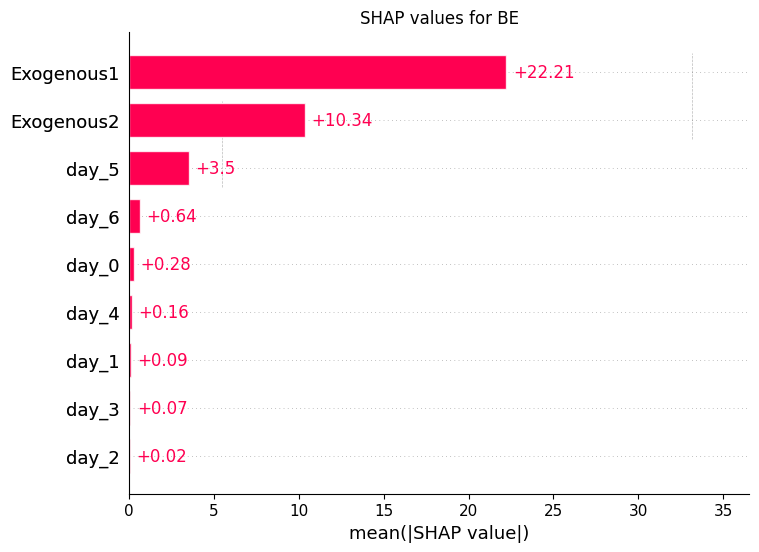

In [ ]:
import shap
import matplotlib.pyplot as plt

shap_columns = shap_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])
shap_values = shap_df[shap_columns].values  # SHAP values matrix
base_values = shap_df['base_value'].values  # Extract base values
features = shap_columns  # Feature names

# Create a SHAP values object
shap_obj = shap.Explanation(values=shap_values, base_values=base_values, feature_names=features)

# Plot the bar plot for SHAP values
shap.plots.bar(shap_obj, max_display=len(features), show=False)
plt.title(f'SHAP values for {market}')
plt.show()

The plot above shows the average SHAP values for each feature across the entire horizon.

Here, we see that `Exogenous1` is the most important feature, as it has the largest average contribution. Remember that it designates the expected energy demand, so we can see that this variable has a large impact on the final prediction. On the other hand, `day_2` is the least important feature, since it has the lowest value.

### 5.2 Waterfall plot

Now, let's see how we can make a waterfall plot to explore the the impact of features at a single prediction step. The code below selects a specific date. Of course, this can be modified for any series or date.

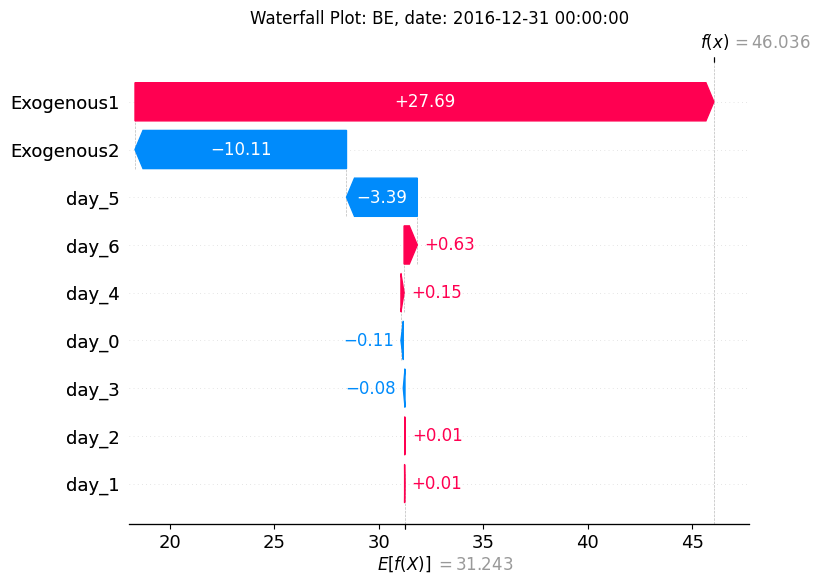

In [ ]:
#| eval: false
selected_ds = shap_df['ds'].min()

filtered_df = shap_df[shap_df['ds'] == selected_ds]

shap_values = filtered_df[shap_columns].values.flatten()
base_value = filtered_df['base_value'].values[0]
features = shap_columns

shap_obj = shap.Explanation(values=shap_values, base_values=base_value, feature_names=features)

shap.plots.waterfall(shap_obj, show=False)
plt.title(f'Waterfall Plot: {market}, date: {selected_ds}')
plt.show()

In the waterfall plot above, we can explore in more detail a single prediction. Here, we study the final prediction for the start of December 24th, 2018.

The x-axis represents the value of our series. At the bottom, we see `E[f(X)]` which represents the baseline value (the predicted value if exogenous features were unknown). 

Then, we see how each feature has impacted the final forecast. Features like `day_3`, `day_0`, `day_5`, `Exogenous2` all push the forecast to the left (smaller value). On the other hand, `day_1`, `day_2`, `day_4`, `day_6` and `Exogenous1` push it to the right (larger value). 

Let’s think about this for a moment. In the introduction, we stated that `Exogenous1` represents electricity load, whereas `Exogenous2` represents electricity generation. 
* `Exogenous1`, the electricity load, adds positively to the overall prediction. This seems reasonable: if we expect a higher demand, we might expect the price to go up.
* `Exogenous2`, on the other hand, adds negatively to the overall prediction. This seems reasonable too: if there’s a higher electricity generation, we expect the price to be lower. Hence, a negative contribution to the forecast for `Exogenous2`.

At the top right, we see f(x) which is the final output of the model after considering the impact of the exogenous features. Notice that this value corresponds to the final prediction from TimeGPT. 

### 5.3 Heatmap
We can also do a heatmap plot to see how each feature impacts the final prediction. Here, we only need to select a specific series.

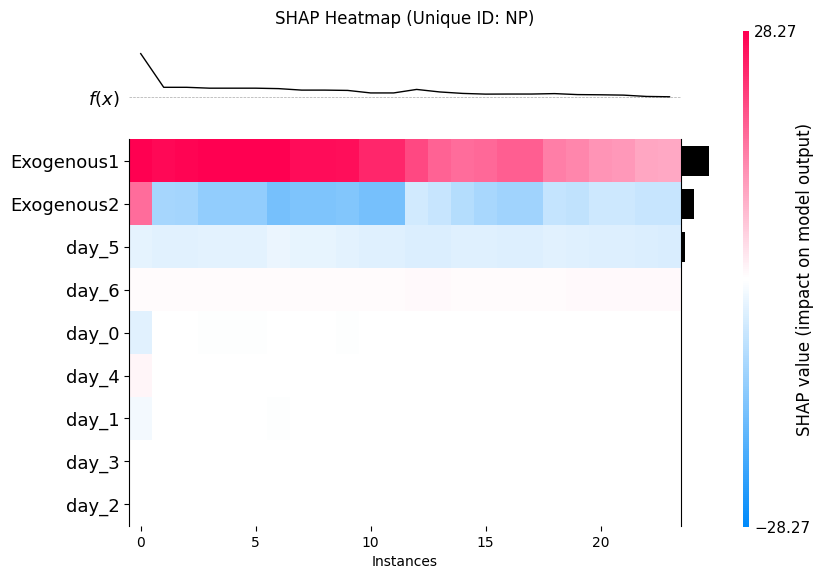

In [ ]:
shap_columns = shap_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])
shap_values = shap_df[shap_columns].values  
feature_names = shap_columns.tolist()

shap_obj = shap.Explanation(values=shap_values, feature_names=feature_names)

shap.plots.heatmap(shap_obj, show=False)
plt.title(f'SHAP Heatmap (Unique ID: NP)')
plt.show()

With the heatmap, we basically see a breakdown of each each feature impacts the final predciton at each timestep.

On the x-axis, we have the number of instances, which corresponds to the number of prediction steps (24 in this case, since our horizon is set to 24h). On the y-axis, we have the name of the exogenous features.

First, notice that the ordering is the same as in the bar plot, where `Exogenous1` is the most important, and `day_6` is the least important.

Then, the color of the heatmap indiciates if the feature tends to increase of decrease the final prediction at each forecasting step. For example, `Exogenous1` always increases predictions across all 24 hours in the forecast horizon.

We also see that all days except `day_5` do not have a very large impact at any forecasting step, indicating that they barely impacting the final prediction.

Ultimately, the `feature_contributions` attribute gives you access to all the necessary information to explain the impact of exogenous features using the `shap` package.